In [1]:
from nodes.nodes import FoldiakNode, InputNode
from nodes.net import FoldiakShapedNet
from nodes.layer import ShapedLayer

import random
import matplotlib.pyplot as plt

random.seed(42)


def reset_network():
    random.seed(42)

    inputlayer = ShapedLayer((8,8))
    foldiaklayer = ShapedLayer(16)

    foldiaklayer.fillnodes(FoldiakNode)
    inputlayer.fillnodes(InputNode)

    network = FoldiakShapedNet()
    network.append(inputlayer)
    network.append(foldiaklayer)
    network.connect_foldiak(inputlayer, foldiaklayer)

    network.setparam("a",0.01)
    network.setparam("b",0.001)
    network.setparam("y",0.01)
    network.setparam("p",1.0/8)
    network.setparam("l",10)
    
    return inputlayer, foldiaklayer, network

In [2]:
inputlayer, foldiaklayer, network = reset_network()

network.setparam("intmethod","LSODA")
network.setparam("dt",0.1)
network.setparam("tnum",100)

In [3]:
#setup code: the two network.update calls handle numba jit compilations.
def net_reset():
    network.setup()
    for i in inputlayer.nodes:
        i.setvalstored(random.uniform(0,1))

    network.update()
    network.update()
    network.meta_timing = []

def timenet(num):
    for i in range(num):
        for j in inputlayer.nodes:
            j.setvalstored(random.uniform(0,1))
        network.update()
    return sum(network.meta_timing)/num

In [4]:
mdict = dict()
intmethods = ["RK45", "RK23", "DOP853", "Radau", "BDF", "LSODA"]
for m in intmethods:
    net_reset()
    network.setparam("intmethod",m)
    mdict[m] = timenet(200)
    print("Finished timing method: " + m)

Finished timing method: RK45
Finished timing method: RK23
Finished timing method: DOP853
Finished timing method: Radau
Finished timing method: BDF
Finished timing method: LSODA


In [5]:
mdict

{'RK45': 0.013023102399999993,
 'RK23': 0.03457965710000009,
 'DOP853': 0.023904311699999903,
 'Radau': 0.03905291040000015,
 'BDF': 0.07056036320000025,
 'LSODA': 0.049880459799999444}

In [41]:
mdict = dict()
network.setparam("dt",1)
network.setparam("tnum",10)
for m in intmethods:
    mtimes = []
    for i in range(30):
        network.setparam("tnum",5*i)
        net_reset()
        network.setparam("intmethod",m)
        mtimes.append(timenet(200))
    mdict[m] = mtimes
    print("Finished timing method: " + m)

Finished timing method: RK45
Finished timing method: RK23
Finished timing method: DOP853
Finished timing method: Radau
Finished timing method: BDF
Finished timing method: LSODA


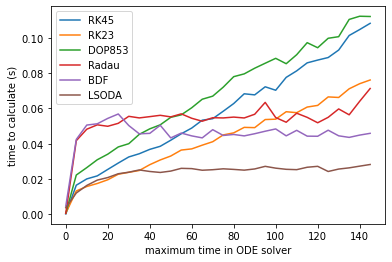

In [42]:
xs = [5*(i) for i in range(30)]
for i in mdict.items():
    plt.plot(xs, i[1], label=i[0])
plt.legend(loc='upper left')
plt.xlabel("maximum time in ODE solver")
plt.ylabel("time to calculate (s)")
plt.savefig("2020_07_07_LEB_intmethod_comparison")
plt.show()